# Decode `.fit` data
Play around and try to decode `.fit` data from Garmin devices. Following instructions taken from [here](https://www.deuxpi.ca/blog/activity-tracking-files.html)

In [1]:
import fitparse
import sys
import matplotlib.pyplot as plt
import datetime
import dateutil
import pytz
import pandas as pd
import numpy as np

In [2]:
def getUniqueValues(lst):
    return list( set(lst) )

These data are downloaded from the Garmin Connect website, and are from May 1st 2019, the whole day (i.e. from 00:00 to 25:59). The first data point in the interactive visualization on the Garmin connect website is 12:00AM-12:02AM.

In [3]:
## 33802246536: has heart rate info ---- this is the one to use
## 33802266527: no heart rate info
## 33803747054: has heart rate info (but much less entries than 33802246536)
## 33803748735: no heart rate info
## 33803750485: no heart rate info
## 33803751953: no heart rate info
input_file = '/Users/francesco/PersonalProjects/data/garmin/2019-05-01/33802246536.fit'
fitfile = fitparse.FitFile(input_file, data_processor=fitparse.StandardUnitsDataProcessor())

In [4]:
type(fitfile)

fitparse.base.FitFile

In [5]:
data_type = []
data_name = []

for record in fitfile.get_messages():
    
    if record.type == 'data':
        data_type.append(record.type)
        data_name.append(record.name)
    
    if record.type == 'data':
        if not record.name == 'monitoring': continue
        print(record.name)
        
        for field_data in record:
            print(' * {}: {}'.format(field_data.name, field_data.value))

monitoring
 * timestamp: 2019-04-30 22:00:00
 * unknown_35: 0
 * unknown_36: 0
monitoring
 * timestamp: 2019-04-30 22:00:00
 * unknown_37: 0
 * unknown_38: 0
monitoring
 * activity_type: sedentary
 * current_activity_type_intensity: (8,)
 * intensity: 0
 * timestamp: 2019-04-30 22:00:00
monitoring
 * heart_rate: 72
 * timestamp_16: 31132
monitoring
 * heart_rate: 76
 * timestamp_16: 31192
monitoring
 * heart_rate: 74
 * timestamp_16: 31252
monitoring
 * heart_rate: 72
 * timestamp_16: 31312
monitoring
 * heart_rate: 82
 * timestamp_16: 31432
monitoring
 * activity_type: sedentary
 * current_activity_type_intensity: (104,)
 * intensity: 3
 * timestamp: 2019-04-30 22:06:00
monitoring
 * heart_rate: 72
 * timestamp_16: 31492
monitoring
 * activity_type: sedentary
 * current_activity_type_intensity: (8,)
 * intensity: 0
 * timestamp: 2019-04-30 22:07:00
monitoring
 * heart_rate: 71
 * timestamp_16: 31552
monitoring
 * activity_type: sedentary
 * current_activity_type_intensity: (72,)
 * in

In [6]:
print('records can be of {} type(s):'.format( len(getUniqueValues(data_type)) ), getUniqueValues(data_type))
print('data names are:', getUniqueValues(data_name))

records can be of 1 type(s): ['data']
data names are: ['stress_level', 'unknown_211', 'unknown_24', 'event', 'ohr_settings', 'unknown_233', 'file_id', 'software', 'monitoring_info', 'device_info', 'monitoring']


As explained [here](https://www.thisisant.com/forum/viewthread/6374/), it is not straightforward to get the exact timestamp. `timestamp_16` is a 16-bit time stamp which has to be added to the offset which is the `timestamp` stored in some earlier `message`.

Reconstructing things by hand, the first `heart_rate` entry in the above dump is:
```
monitoring
 * heart_rate: 72
 * timestamp_16: 31132
```
while the last `timestamp` before it is `* timestamp: 2019-04-30 22:00:00`

In [13]:
utc_reference = int(datetime.datetime.timestamp(datetime.datetime(1989,12,31)))

dt_offset = datetime.datetime(2019,4,30,22,0,0,0,pytz.timezone('Europe/Zurich'))
timestamp = int(datetime.datetime.timestamp(dt_offset))
timestamp_16 = 31132

print('utc_reference:', utc_reference)
print('timestamp:', timestamp)
print('timestamp_16:', timestamp_16)

utc_reference: 631062000
ts_offset: 1556659800
timestamp_16: 31132


In [14]:
mesgTimestamp = timestamp
mesgTimestamp += ( timestamp_16 - ( mesgTimestamp & 0xFFFF ) ) & 0xFFFF

print('Garmin recipe:', datetime.datetime.fromtimestamp(mesgTimestamp))
print('timestamp:', datetime.datetime.fromtimestamp(timestamp))
print('timestamp + timestamp_16:', datetime.datetime.fromtimestamp(timestamp + timestamp_16))

Garmin recipe: 2019-05-01 12:49:00
timestamp: 2019-04-30 23:30:00
timestamp + timestamp_16: 2019-05-01 08:08:52


Following the instructions linked above, the trick should be to simply replace the last 16 bits of `ts_offset` with the last 16 bits of `timestamp_16` (which, in principle, should be the whole `timestamp_16` since it is a 16-bit variable).

In [15]:
print('binary timestamp_16: xxxxxxxxxxxxxxxx{}'.format(bin(timestamp_16)[2:]))
print('binary timestamp   :', bin(timestamp)[2:])
print('result             :', bin(mesgTimestamp)[2:])

binary timestamp_16: xxxxxxxxxxxxxxxx111100110011100
binary timestamp   : 1011100110010001011111001011000
result             : 1011100110010010111100110011100


**Note**: the last two bits of the first 16, are actually flipped!

In [16]:
# set the last 16 bits of timsestamp to 0
step1 = timestamp# & 0xFFFF8000
print(step1)
print(bin(timestamp)[2:])
print(bin(step1)[2:])

1556659800
1011100110010001011111001011000
1011100110010001011111001011000


OK, this is working

In [79]:
# get the last 16 bits of timestamp_16
step2 = np.int16(timestamp_16) & 0xFFFF
step2
print(bin(timestamp_16)[2:])
print(bin(step2)[2:])

111100110011100
111100110011100


In [82]:
# set the last 16 bits of timestamp to the last 16 bits of timestamp_16
step3 = int( bin(step1)[2:18] + bin(step2)[2:], 2 )
print(step3)
print('n bits:', len(bin(step3)[2:]))
print(bin(timestamp)[2:])
#print(bin(step1)[2:])
print('xxxxxxxxxxxxxxxx' + bin(step2)[2:])
print(bin(step3)[2:])

1556674972
n bits: 31
1011100110010001011111001011000
xxxxxxxxxxxxxxxx111100110011100
1011100110010001111100110011100


In [81]:
datetime.datetime.fromtimestamp(step3)

datetime.datetime(2019, 5, 1, 3, 42, 52)

uhm ... nope

another attempt: apply Garmin's recipe step by step

In [17]:
dt_offset = datetime.datetime(2019,4,30,22,0,0,0,pytz.timezone('Europe/Zurich'))
timestamp = int(datetime.datetime.timestamp(dt_offset))
timestamp_16 = 31132

print('utc_reference:', utc_reference)
print('timestamp:', timestamp)
print('timestamp_16:', timestamp_16)

utc_reference: 631062000
ts_offset: 1556659800
timestamp_16: 31132


In [42]:
mesgTimestamp = timestamp
#mesgTimestamp += ( timestamp_16 - ( mesgTimestamp & 0xFFFF ) ) & 0xFFFF
print('data:')
print( 'mesgTimestamp: 2019-04-30 22:00:00 -> 1556659800 : {:>35}'.format(bin(mesgTimestamp)) )
print( 'timestamp_16: 31132                              : {:>35}'.format(bin(timestamp_16)) )

print('start:')
step1 = mesgTimestamp & 0xFFFF
print( 'step1: mesgTimestamp & 0xFFFF                    : {:>35}'.format( bin(step1)) )

step2 = timestamp_16 - step1
print( 'step2: timestamp_16 - step1                      : {:>35}'.format(bin(step2)) )

step3 = step2 & 0xFFFF
print( 'step3: step2 & 0xFFFF                            : {:>35}'.format(bin(step3)) )

step4 = mesgTimestamp + step3
print( 'step4: mesgTimestamp + step3                     : {:>35}'.format(bin(step3)), '->', step4, '->', datetime.datetime.fromtimestamp(step4))

data:
mesgTimestamp: 2019-04-30 22:00:00 -> 1556659800 :   0b1011100110010001011111001011000
timestamp_16: 31132                              :                   0b111100110011100
start:
step1: mesgTimestamp & 0xFFFF                    :                  0b1011111001011000
step2: timestamp_16 - step1                      :                  -0b100010010111100
step3: step2 & 0xFFFF                            :                  0b1011101101000100
step4: mesgTimestamp + step3                     :                  0b1011101101000100 -> 1556707740 -> 2019-05-01 12:49:00


In [19]:
ts = []
hr = []
timestamp = None

for record in fitfile.get_messages():
    
    # get only the "data"
    if record.type != 'data':
        continue
    
    this_record = record.as_dict()
    print()
    #print(this_record)
    for entry in this_record.keys(): print(entry, this_record[entry])
    
    for field in this_record['fields']:
        
        # get the timestamp
        if field['name'] == 'timestamp':
            timestamp = field['raw_value']
            #print(timestamp)
        if timestamp is None:
            continue
        
        elif field['name'] == 'timestamp_16':
            timestamp_16 = field['raw_value']
            this_timestamp = timestamp
            this_timestamp += (timestamp_16 - (this_timestamp & 0xffff)) & 0xffff
            
        elif field['name'] == 'heart_rate':
            heart_rate = field['raw_value']
            ts.append(timestamp)
            #ts.append(631065600 + timestamp) # alternative, but it's not taking timestamp_16 into account
            hr.append(heart_rate)


name file_id
fields [{'name': 'serial_number', 'def_num': 3, 'base_type': 'uint32z', 'type': 'uint32z', 'units': None, 'value': 3964402232, 'raw_value': 3964402232}, {'name': 'time_created', 'def_num': 4, 'base_type': 'uint32', 'type': 'date_time', 'units': None, 'value': datetime.datetime(2019, 4, 30, 22, 0), 'raw_value': 925596000}, {'name': 'manufacturer', 'def_num': 1, 'base_type': 'uint16', 'type': 'manufacturer', 'units': None, 'value': 'garmin', 'raw_value': 1}, {'name': 'garmin_product', 'def_num': 2, 'base_type': 'uint16', 'type': 'garmin_product', 'units': None, 'value': 2623, 'raw_value': 2623}, {'name': 'number', 'def_num': 5, 'base_type': 'uint16', 'type': 'uint16', 'units': None, 'value': 135, 'raw_value': 135}, {'name': 'unknown_6', 'def_num': 6, 'base_type': 'uint16', 'type': 'uint16', 'units': None, 'value': None, 'raw_value': None}, {'name': 'type', 'def_num': 0, 'base_type': 'enum', 'type': 'file', 'units': None, 'value': 'monitoring_b', 'raw_value': 32}]

name devi

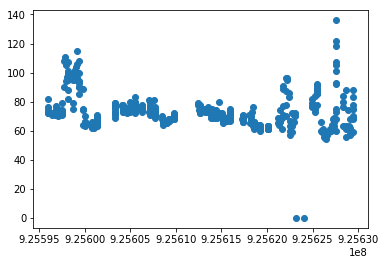

In [10]:
plt.scatter(ts, hr)

In [11]:
#print(datetime.datetime.utcfromtimestamp(ts[0]))
#for entry in ts: print(datetime.datetime.utcfromtimestamp(entry))

This still needs some work, but I guess this is related to the actual format.
e.g. the first `timestamp` I find is `925596000`, which is translated to `datetime.datetime(2019, 4, 30, 22, 0)` in the Gamin device, while python converts it to `1999-05-01 22:01:00`, i.e. about 20 years earlier :\

Also, there are holes in the above spectrum.

Below some previous studies ..

In [12]:
HR_list = []
for record in fitfile.get_messages('monitoring'):
    #print(record.as_dict())
    
    this_record = record.as_dict()
    
    for field in this_record['fields']:
        if 'heart_rate' in field['name']:
            print(this_record)
            HR_list.append(this_record)

{'name': 'monitoring', 'fields': [{'name': 'timestamp_16', 'def_num': 26, 'base_type': 'uint16', 'type': 'uint16', 'units': 's', 'value': 31132, 'raw_value': 31132}, {'name': 'heart_rate', 'def_num': 27, 'base_type': 'uint8', 'type': 'uint8', 'units': 'bpm', 'value': 72, 'raw_value': 72}]}
{'name': 'monitoring', 'fields': [{'name': 'timestamp_16', 'def_num': 26, 'base_type': 'uint16', 'type': 'uint16', 'units': 's', 'value': 31192, 'raw_value': 31192}, {'name': 'heart_rate', 'def_num': 27, 'base_type': 'uint8', 'type': 'uint8', 'units': 'bpm', 'value': 76, 'raw_value': 76}]}
{'name': 'monitoring', 'fields': [{'name': 'timestamp_16', 'def_num': 26, 'base_type': 'uint16', 'type': 'uint16', 'units': 's', 'value': 31252, 'raw_value': 31252}, {'name': 'heart_rate', 'def_num': 27, 'base_type': 'uint8', 'type': 'uint8', 'units': 'bpm', 'value': 74, 'raw_value': 74}]}
{'name': 'monitoring', 'fields': [{'name': 'timestamp_16', 'def_num': 26, 'base_type': 'uint16', 'type': 'uint16', 'units': 's'

In [10]:
#HR_list[0]

Example HR record looks like this:
```
{'name': 'monitoring',
  'fields': [{'name': 'timestamp_16',
    'def_num': 26,
    'base_type': 'uint16',
    'type': 'uint16',
    'units': 's',
    'value': 31132,
    'raw_value': 31132},
   {'name': 'heart_rate',
    'def_num': 27,
    'base_type': 'uint8',
    'type': 'uint8',
    'units': 'bpm',
    'value': 72,
    'raw_value': 72}]}
```

In [10]:
HR_timestamp = []
HR_value = []
for entry in HR_list:
    HR_timestamp.append( entry['fields'][0]['value'] )
    HR_value.append( entry['fields'][1]['value'] )

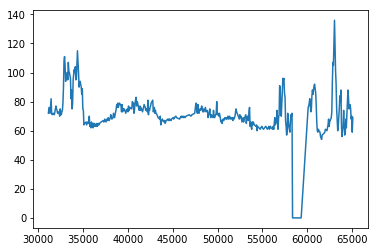

In [11]:
plt.figure()
plt.plot(HR_timestamp, HR_value)

In [134]:
## trying to get the right point in time: from Garmin Connect, the first measured point is at midnight of 2019-05-01

#offset = (datetime.datetime.strptime('2019-04-30 22:00:00', '%Y-%m-%d %H:%M:%S') - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
offset = (datetime.datetime.strptime('2019-05-01', '%Y-%m-%d') - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
for entry in HR_timestamp:
    print(entry, np.uint8(entry))
    print(entry, '-', datetime.datetime.utcfromtimestamp(entry).strftime('%Y-%m-%d %H:%M:%S'), '-', datetime.datetime.utcfromtimestamp(entry + offset).strftime('%Y-%m-%d %H:%M:%S'))
    print(entry, '-', datetime.datetime.utcfromtimestamp(np.uint8(entry)).strftime('%Y-%m-%d %H:%M:%S'), '-', datetime.datetime.utcfromtimestamp(np.uint8(entry) + offset).strftime('%Y-%m-%d %H:%M:%S'))

31132 156
31132 - 1970-01-01 08:38:52 - 2019-05-01 08:38:52
31132 - 1970-01-01 00:02:36 - 2019-05-01 00:02:36
31192 216
31192 - 1970-01-01 08:39:52 - 2019-05-01 08:39:52
31192 - 1970-01-01 00:03:36 - 2019-05-01 00:03:36
31252 20
31252 - 1970-01-01 08:40:52 - 2019-05-01 08:40:52
31252 - 1970-01-01 00:00:20 - 2019-05-01 00:00:20
31312 80
31312 - 1970-01-01 08:41:52 - 2019-05-01 08:41:52
31312 - 1970-01-01 00:01:20 - 2019-05-01 00:01:20
31432 200
31432 - 1970-01-01 08:43:52 - 2019-05-01 08:43:52
31432 - 1970-01-01 00:03:20 - 2019-05-01 00:03:20
31492 4
31492 - 1970-01-01 08:44:52 - 2019-05-01 08:44:52
31492 - 1970-01-01 00:00:04 - 2019-05-01 00:00:04
31552 64
31552 - 1970-01-01 08:45:52 - 2019-05-01 08:45:52
31552 - 1970-01-01 00:01:04 - 2019-05-01 00:01:04
31672 184
31672 - 1970-01-01 08:47:52 - 2019-05-01 08:47:52
31672 - 1970-01-01 00:03:04 - 2019-05-01 00:03:04
31792 48
31792 - 1970-01-01 08:49:52 - 2019-05-01 08:49:52
31792 - 1970-01-01 00:00:48 - 2019-05-01 00:00:48
31972 228
31972 